In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import ToTensor

from tqdm import tqdm, trange

from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

from numpy.typing import NDArray
from typing import Tuple

np.random.seed(0)
torch.manual_seed(0)

RSEED = 0
BATCH = 32

In [39]:
with ZipFile("Colorectal_Histology.zip", "r") as zObject:
    zObject.extractall(path=".")

In [40]:
df = pd.read_csv("hmnist_64_64_L.csv")
X = df.drop('label', axis=1)
X = X.to_numpy()
y = df.label.to_numpy()


In [41]:
df.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,label
0,134,99,119,130,142,169,152,139,117,87,...,112,89,73,100,120,120,126,140,195,2
1,55,64,74,63,74,75,71,73,70,77,...,79,85,86,77,68,66,65,68,69,2
2,114,116,136,152,132,100,151,150,127,205,...,128,157,159,205,182,143,129,89,122,2
3,86,82,88,85,103,93,98,109,104,115,...,79,80,109,128,89,85,80,63,48,2
4,168,143,140,139,129,123,123,141,137,101,...,231,199,183,195,179,134,142,158,149,2
5,124,122,104,100,88,58,58,49,70,72,...,155,160,135,143,161,181,135,110,107,2
6,167,173,177,180,198,182,182,173,208,196,...,137,118,134,149,131,113,178,197,181,2
7,64,53,95,108,123,120,145,153,134,142,...,97,105,112,118,74,42,39,36,34,2
8,152,157,163,164,159,154,160,159,156,151,...,121,130,154,151,147,148,141,127,140,2
9,142,144,147,157,168,172,172,181,184,196,...,204,158,106,145,146,102,106,122,167,2


In [42]:
type(y)

numpy.ndarray

In [43]:
X

array([[134,  99, 119, ..., 126, 140, 195],
       [ 55,  64,  74, ...,  65,  68,  69],
       [114, 116, 136, ..., 129,  89, 122],
       ...,
       [ 30,  29,  37, ..., 195,  83,  45],
       [105, 115, 108, ...,  77,  81,  85],
       [ 60,  77,  84, ...,  90,  64,  67]], shape=(5000, 4096))

In [44]:
class histo(Dataset):
    def __init__(self, X:NDArray[np.int8], y:NDArray[np.int8])->None:
        X = torch.tensor(X, dtype=torch.uint8).view(-1, 1, 64, 64)
        self.X = X.float()/255
        if y is None:
            self.y = None
        else:
            self.y = y

    def __len__(self)->int:
        return len(self.X)
    
    def __getitem__(self, idx:int)->int:
        return self.X[idx], self.y[idx]
    
    @staticmethod
    def create_split(X, y, train_fraction:float, val_fraction:float, test_fraction:float)->Tuple[Dataset, Dataset, Dataset]:
        assert train_fraction + val_fraction + test_fraction <= 1

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_fraction)

        train_data = histo(X_train, y_train)
        val_data = histo(X_val, y_val)

        return train_data, val_data


In [45]:
train_data, val_data = histo.create_split(X, y, 0.5, 0.5,0.0)

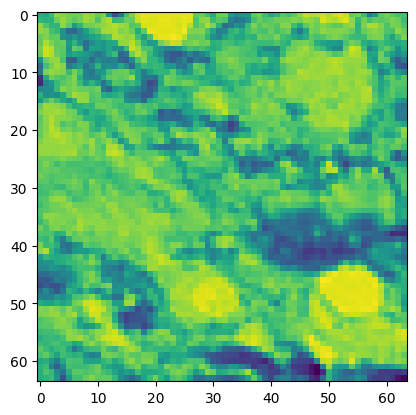

In [ ]:
# plt.imshow(np.swapaxes(, 0,2))
image = train_data[1][0]
image_np = image.numpy()
transpose_image_np = np.transpose(image, (1,2,0))
plt.imshow(transpose_image_np)

In [47]:
def  main():


    train_loader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ViTModel((1, 28, 28), n_patches=16, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    num_epochs = 4
    learn_rate = 0.005

    optimizer = Adam(model.parameters(), lr=learn_rate)
    loss_fn = CrossEntropyLoss()

    for epoch in trange(num_epochs, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch +1} in training", leave=False):
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            train_loss += loss.detach().cpu().item()/len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} loss: {train_loss:.3f}")

        with torch.no_grad():
            correct, total = 0,  0

            test_loss = 0.0

            for batch in tqdm(val_loader, desc="Testing"):
                X, y = batch
                X, y = X.to(device), y.to(device)

                y_pred = model(X)

                loss = loss_fn(y_pred, y)

                test_loss += loss.detach().cpu().item()/len(val_loader)

                correct += torch.sum(torch.argmax(y_pred, dim=1)==y).detach().cpu().item()
                total += len(X)
            print(f"Test loss: {test_loss:.3f}")
            print(f"Test accuracy: {correct/total*100:.3f}")



    

In [48]:
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()

    def foward(self):
        pass

In [49]:
def make_patches(images, num_patches):
    n, c, h, w = images.shape

    assert h == w

    patches = torch.zeros(n, num_patches**2, h*w*c//num_patches**2)
    patch_size = h//num_patches

    for idx, image in enumerate(images):
        for i in num_patches:
            for j in num_patches:
                patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                patches[idx, i*num_patches+j] = patch.flatten()
    return patches